### 1. Data Ingestion

In [1]:
from cityscapesscripts.download import downloader
import torch
from torch.utils.data import Dataset, DataLoader  # Import Dataset and DataLoader
from PIL import Image
import json
import glob
import os
import numpy as np
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt

In [2]:
# #registered at cityscapes-dataset.com

# session = downloader.login()
# downloader.get_available_packages(session=session)

# #data choice
# print('downloading gtfine and leftImg8bit packages ... \n')

# package_list = {'gtFine_trainvaltest.zip', 'leftImg8bit_trainvaltest.zip','vehicle_trainvaltest.zip'}
# downloader.download_packages(session=session, package_names=package_list, destination_path='/Data')

### 2. Preprocessing

In [3]:
# Create Training dataset for GT Fine color
#GT Fine Folder structure: 'gtFine_trainvaltest'  --> 'gtFine' --> train --> folders for all available cities (berlin, muncih, bielefeld, etc.) --> actual image: eg aachen_000000_000019_gtFine_color.png
#create Training dataset for RGB image
# RGB Image Folder Structure: 'leftImg8bit_trainvaltest' --> lefImg8bit --> train --> folder for all available cities --> actual image: eg aachen_000000_000019_leftImg8bit.png
# create Training Dataset for car Odometry json files. 
# aachen_000000_000019_vehicle.json

#do the same for validation Data


In [4]:
# class CustomDataset(Dataset):
#     def __init__(self, root_dir, split='train'):
#         self.root_dir = root_dir
#         self.split = split
#         self.img_dir = os.path.join(root_dir, f'leftImg8bit_trainvaltest/leftImg8bit/{split}')
#         self.mask_dir = os.path.join(root_dir, f'gtFine_trainvaltest/gtFine/{split}')
#         self.json_dir = os.path.join(root_dir, f'vehicle_trainvaltest/vehicle/{split}')
#         self.img_list = glob.glob(f'{self.img_dir}/*/*_leftImg8bit.png')

#     def __len__(self):
#         return len(self.img_list)

#     def __getitem__(self, idx):
#         img_path = self.img_list[idx]
#         city, filename = os.path.split(img_path)
#         city = os.path.basename(city)
#         base_filename = filename.split('_leftImg8bit.png')[0]
#         mask_path = os.path.join(self.mask_dir, city, f'{base_filename}_gtFine_color.png')
#         json_path = os.path.join(self.json_dir, city, f'{base_filename}_vehicle.json')

#         # Load image and mask
#         img = Image.open(img_path).convert('RGB')
#         mask = Image.open(mask_path).convert('L')  # Assuming masks are single channel
        
#         # Resize image and mask to 300x150 while maintaining aspect ratio
#         img = img.resize((300, 150), Image.ANTIALIAS)
#         mask = mask.resize((300, 150), Image.NEAREST)
        
#         # Load json and extract temperature value
#         with open(json_path, 'r') as f:
#             data = json.load(f)
#         temperature = data['outsideTemperature']  # Assuming temperature is a key in your JSON

#         # Convert to PyTorch tensors
#         img = torch.tensor(np.array(img), dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize to [0, 1]
#         mask = torch.tensor(np.array(mask), dtype=torch.long)  # Assuming mask is not normalized
#         temperature = torch.tensor(temperature, dtype=torch.float32)

#         return img, mask, temperature

# # Usage:
# root_dir = 'Data'
# train_dataset = CustomDataset(root_dir, split='train')
# val_dataset = CustomDataset(root_dir, split='val')

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [5]:
#dataloaaed just for regression
class CustomDataset(Dataset):
    def __init__(self, root_dir, split='train'):
        self.root_dir = root_dir
        self.split = split
        self.img_dir = os.path.join(root_dir, f'leftImg8bit_trainvaltest/leftImg8bit/{split}')
        self.mask_dir = os.path.join(root_dir, f'gtFine_trainvaltest/gtFine/{split}')
        self.json_dir = os.path.join(root_dir, f'vehicle_trainvaltest/vehicle/{split}')
        self.img_list = glob.glob(f'{self.img_dir}/*/*_leftImg8bit.png')

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        city, filename = os.path.split(img_path)
        city = os.path.basename(city)
        base_filename = filename.split('_leftImg8bit.png')[0]
        json_path = os.path.join(self.json_dir, city, f'{base_filename}_vehicle.json')

        # Load image
        img = Image.open(img_path).convert('RGB')

        # Resize image to 300x150 while maintaining aspect ratio
        img = img.resize((300, 150), Image.LANCZOS)  # Note: Updated to use LANCZOS as per the deprecation warning
        
        # Load json and extract temperature value
        with open(json_path, 'r') as f:
            data = json.load(f)
        temperature = data['outsideTemperature']  # Assuming temperature is a key in your JSON

        # Convert to PyTorch tensors
        img = torch.tensor(np.array(img), dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize to [0, 1]
        temperature = torch.tensor(temperature, dtype=torch.float32)

        return img, temperature  # Return only image and temperature
    
# Usage:
root_dir = 'Data'
train_dataset = CustomDataset(root_dir, split='train')
val_dataset = CustomDataset(root_dir, split='val')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:
# img,mask,temp=next(iter(train_loader))

In [7]:
# import matplotlib.pyplot as plt
# import numpy as np

# def display_random_samples(train_loader):
#     # Get a random batch of data
#     img_batch, mask_batch, temp_batch = next(iter(train_loader))
    
#     # Randomly select 5 indices from the batch
#     random_indices = np.random.choice(img_batch.shape[0], 5, replace=False)
    
#     fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    
#     for i, idx in enumerate(random_indices):
#         # Get the corresponding image, mask, and temperature
#         img = img_batch[idx].permute(1, 2, 0).numpy()
#         mask = mask_batch[idx].squeeze(0).numpy()
#         temperature = temp_batch[idx].item()
        
#         # Set the temperature as the title for each column
#         axs[0, i].set_title(f'Temperature: {temperature}°C')
        
#         # Display the mask (annotation)
#         axs[0, i].imshow(mask, cmap='jet')
#         axs[0, i].axis('off')
        
#         # Display the RGB image
#         axs[1, i].imshow(img)
#         axs[1, i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# # Usage:
# display_random_samples(train_loader)


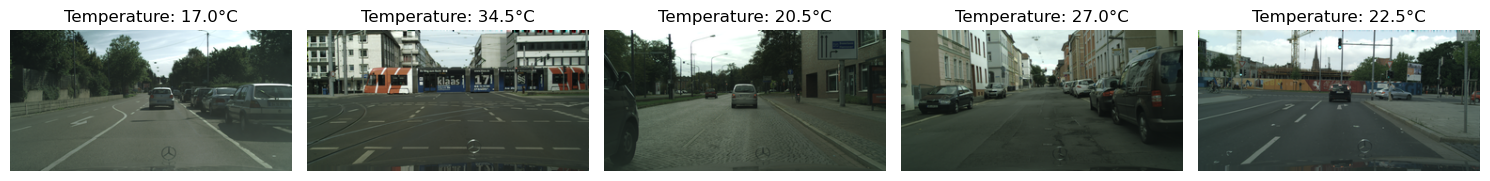

In [8]:
#plot random pictures weith temperature

def display_random_samples(train_loader):
    # Get a random batch of data
    img_batch, temp_batch = next(iter(train_loader))  # Updated to match the updated data loader
    
    # Randomly select 5 indices from the batch
    random_indices = np.random.choice(img_batch.shape[0], 5, replace=False)
    
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # Adjusted subplot layout to 1 row and 5 columns
    
    for i, idx in enumerate(random_indices):
        # Get the corresponding image and temperature
        img = img_batch[idx].permute(1, 2, 0).numpy()
        temperature = temp_batch[idx].item()
        
        # Set the temperature as the title for each column
        axs[i].set_title(f'Temperature: {temperature}°C')
        
        # Display the RGB image
        axs[i].imshow(img)
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage:
display_random_samples(train_loader)

### 3. Model   

In [9]:


# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         resnet = models.resnet18(pretrained=True)
#         self.features = nn.Sequential(*list(resnet.children())[:-2])  # Exclude last two layers

#     def forward(self, x):
#         x = self.features(x)
#         print(x.size())  # Debugging line to check dimensions
#         return x
    
# # class SegmentationHead(nn.Module):
# #     def __init__(self, in_channels, num_classes):
# #         super(SegmentationHead, self).__init__()
        
# #         self.conv1 = nn.Conv2d(in_channels, num_classes, kernel_size=1)
# #         self.upsample = nn.Upsample(size=(150, 300), mode='bilinear', align_corners=True)
        
# #     def forward(self, x):
# #         x = self.conv1(x)
# #         x = self.upsample(x)
# #         print(x.size())

# #         return x

# class RegressionHead(nn.Module):
#     def __init__(self, flattened_size):
#         super(RegressionHead, self).__init__()
#         self.fc = nn.Linear(flattened_size, 1)

#     def forward(self, x):
#         return self.fc(x.flatten(1))

# class MultiTaskNetwork(nn.Module):
#     # def __init__(self, num_classes, flattened_size):
#     def __init__(self,  flattened_size):
#         super(MultiTaskNetwork, self).__init__()
#         self.encoder = Encoder()
#         # self.segmentation_head = SegmentationHead(in_channels=512, num_classes=num_classes)
#         self.regression_head = RegressionHead(flattened_size=flattened_size)

#     def forward(self, x):
#         x = self.encoder(x)
#         # segmentation_output = self.segmentation_head(x)
#         regression_output = self.regression_head(x)
#         # return segmentation_output, regression_output
#         return regression_output
# # Get the flattened size
# dummy_input = torch.randn(1, 3, 300, 150)  # Updated resolution
# encoder = Encoder()
# flattened_size = np.prod(encoder(dummy_input).size()[1:])

# # Instantiate the model
# # num_classes = 30  # Adjusted to match the number of classes in your annotations
# # model = MultiTaskNetwork(num_classes=num_classes, flattened_size=flattened_size)
# model = MultiTaskNetwork(flattened_size=flattened_size)


In [10]:

# # If you have a GPU
# if torch.cuda.is_available():
#     model = model.cuda()

# criterion_regression = nn.MSELoss()  # loss for regression
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 10  # Define the number of epochs you want to train for

# # Training loop
# for epoch in range(num_epochs):
#     for data in train_loader:
#         inputs, regression_target = data
        
#         # If you have a GPU
#         if torch.cuda.is_available():
#             inputs = inputs.cuda()
#             regression_target = regression_target.cuda()

#         optimizer.zero_grad()
#         regression_output = model(inputs)
#         loss = criterion_regression(regression_output, regression_target)
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

In [ ]:
# Model Setup 
import torch.nn as nn
from torchvision import models

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])

    def forward(self, x):
        x = self.features(x)
        # print(x.size())  # Debugging line to check dimensions
        return x
    
class RegressionHead(nn.Module):
    def __init__(self, flattened_size):
        super(RegressionHead, self).__init__()
        self.fc = nn.Linear(flattened_size, 1)

    def forward(self, x):
        x = self.fc(x.flatten(1))
        return x.squeeze()  # Squeeze the output tensor to match the target tensor's shape

class RegressionNetwork(nn.Module):
    def __init__(self, flattened_size):
        super(RegressionNetwork, self).__init__()
        self.encoder = Encoder()
        self.regression_head = RegressionHead(flattened_size=flattened_size)

    def forward(self, x):
        x = self.encoder(x)
        regression_output = self.regression_head(x)
        return regression_output


In [ ]:
#Training prep (optimizer)

# Get the flattened size
dummy_input = torch.randn(1, 3, 300, 150)  # Updated resolution
encoder = Encoder()
flattened_size = np.prod(encoder(dummy_input).size()[1:])

# Instantiate the model
model = RegressionNetwork(flattened_size=flattened_size)

# If you have a GPU
if torch.cuda.is_available():
    model = model.cuda()

criterion_regression = nn.MSELoss()  # loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Training Loss: 31.917830036532493
Epoch 1/10, Validation Loss: 68.74523112177849
Saving the best model so far to best_model.pth
Epoch 2/10, Training Loss: 18.44509453927317
Epoch 2/10, Validation Loss: 78.45875763893127
Epoch 3/10, Training Loss: 19.541653956136397
Epoch 3/10, Validation Loss: 53.560115814208984
Saving the best model so far to best_model.pth
Epoch 4/10, Training Loss: 21.32800143764865
Epoch 4/10, Validation Loss: 39.348352044820786
Saving the best model so far to best_model.pth
Epoch 5/10, Training Loss: 16.170492233768588
Epoch 5/10, Validation Loss: 35.93090492486954
Saving the best model so far to best_model.pth
Epoch 6/10, Training Loss: 16.646778142580423
Epoch 6/10, Validation Loss: 20.914037823677063
Saving the best model so far to best_model.pth
Epoch 7/10, Training Loss: 17.774829238973638
Epoch 7/10, Validation Loss: 28.39693593978882
Epoch 8/10, Training Loss: 12.51103812904768
Epoch 8/10, Validation Loss: 26.022984355688095
Epoch 9/10, Training

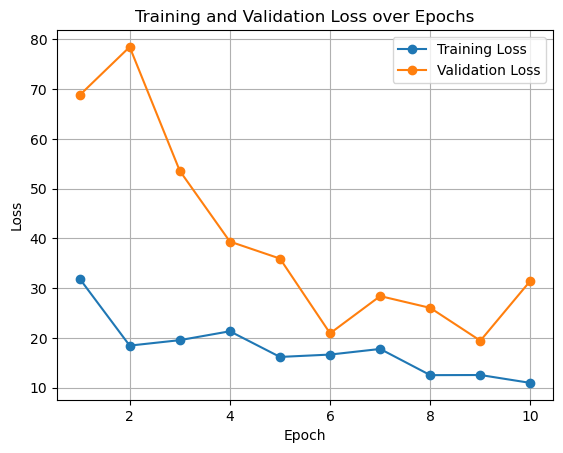

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [11]:
# Training setup
num_epochs = 10
save_path = 'best_model.pth'  # Specify the path where you want to save the best model
best_val_loss = float('inf')  # Set initial "best" to infinity
loss_history = []  # Initialize an empty list to store the training loss history
val_loss_history = []  # Initialize an empty list to store the validation loss history

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0
    for data in train_loader:
        inputs, regression_target = data
        
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            regression_target = regression_target.cuda()

        optimizer.zero_grad()
        regression_output = model(inputs)
        loss = criterion_regression(regression_output, regression_target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss}')
    loss_history.append(epoch_loss)  # Append the average epoch loss to loss_history


   # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, regression_target = data

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                regression_target = regression_target.cuda()

            regression_output = model(inputs)
            loss = criterion_regression(regression_output, regression_target)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}')
    val_loss_history.append(val_loss)  # Append the average validation loss to val_loss_history

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f'Saving the best model so far to {save_path}')
        torch.save(model.state_dict(), save_path)  # Save the best model to the specified path

# Plot the loss history
plt.figure()
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [16]:

# # Visualize some predictions
# def visualize_predictions(model, val_loader):
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():
#         # Get a batch of data from the validation loader
#         inputs, regression_target = next(iter(val_loader))
#         # If you have a GPU
#         if torch.cuda.is_available():
#             inputs = inputs.cuda()
#         # Get the model's predictions
#         predictions = model(inputs)
#         # If you have a GPU
#         if torch.cuda.is_available():
#             predictions = predictions.cpu()
#         # Select a few random indices
#         random_indices = np.random.choice(inputs.shape[0], 5, replace=False)
#         for i, idx in enumerate(random_indices):
#             # Get the corresponding inputs, targets, and predictions
#             img = inputs[idx].cpu().permute(1, 2, 0).numpy()  # Transfer tensor to CPU before converting to numpy
#             true_temp = regression_target[idx].item()
#             pred_temp = predictions[idx].item()
#             # Display the image along with the true and predicted temperatures
#             plt.figure()
#             plt.imshow(img)
#             plt.title(f'True Temperature: {true_temp}°C, Predicted Temperature: {pred_temp:.2f}°C')
#             plt.axis('off')
#             plt.show()

# # Usage:
# visualize_predictions(model, val_loader)

In [14]:
# Load the best model
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

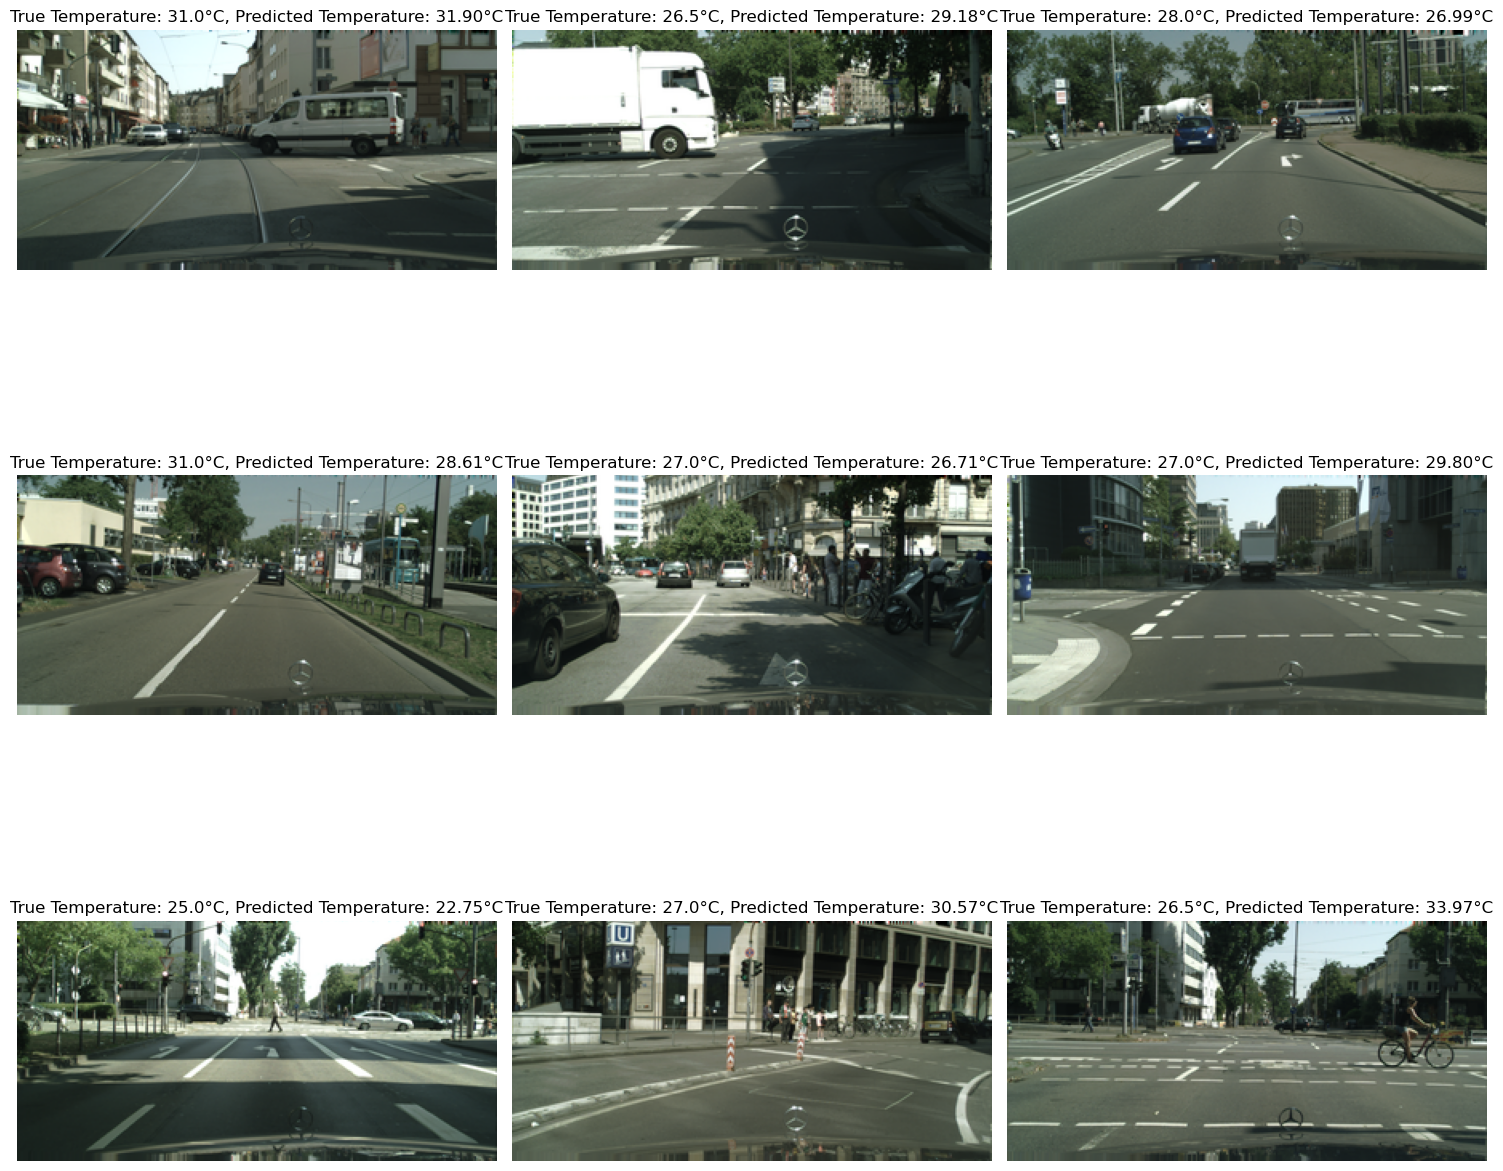

In [15]:
def visualize_predictions(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Get a batch of data from the validation loader
        inputs, regression_target = next(iter(val_loader))
        # If you have a GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()
        # Get the model's predictions
        predictions = model(inputs)
        # If you have a GPU
        if torch.cuda.is_available():
            predictions = predictions.cpu()
            inputs = inputs.cpu()  # Move inputs to CPU
            regression_target = regression_target.cpu()  # Move regression_target to CPU
        
        # Select 9 random indices
        random_indices = np.random.choice(inputs.shape[0], 9, replace=False)
        
        # Create a 3x3 grid of subplots
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))
        
        for i, idx in enumerate(random_indices):
            # Get the corresponding inputs, targets, and predictions
            img = inputs[idx].permute(1, 2, 0).numpy()
            true_temp = regression_target[idx].item()
            pred_temp = predictions[idx].item()
            
            # Determine the position of the subplot in the grid
            row = i // 3
            col = i % 3
            
            # Display the image along with the true and predicted temperatures
            axs[row, col].imshow(img)
            axs[row, col].set_title(f'True Temperature: {true_temp}°C, Predicted Temperature: {pred_temp:.2f}°C')
            axs[row, col].axis('off')
        
        plt.tight_layout()  # Adjusts the spacing between subplots for better readability
        plt.show()

# Usage:
visualize_predictions(model, val_loader)


In [17]:
import geopandas as gpd
import os
import json
import folium
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import branca.colormap as cm

# Function to get predictions and actual temperatures
def get_predictions_and_actuals(model, val_loader, root_dir):
    model.eval()
    predictions = []
    actuals = []  # List to store the actual temperature values
    coords = []
    total_images_processed = 0  # Counter to keep track of the total number of images processed
    with torch.no_grad():
        for data in val_loader:
            inputs, regression_target = data

            if torch.cuda.is_available():
                inputs = inputs.cuda()

            outputs = model(inputs)

            if torch.cuda.is_available():
                outputs = outputs.cpu()

            predictions.extend(outputs.numpy())
            
            # Retrieve actual temperature values from the JSON files
            actuals.extend(regression_target.numpy())  # Assuming regression_target is a tensor of actual temperatures
            
            # Calculate the index of each image within the dataset
            for i in range(total_images_processed, total_images_processed + len(inputs)):
                img_path = val_loader.dataset.img_list[i]
                city, filename = os.path.split(img_path)
                city = os.path.basename(city)
                base_filename = filename.split('_leftImg8bit.png')[0]
                json_path = os.path.join(root_dir, f'vehicle_trainvaltest/vehicle/val/{city}/{base_filename}_vehicle.json')
                with open(json_path, 'r') as f:
                    json_data = json.load(f)
                coords.append((json_data['gpsLatitude'], json_data['gpsLongitude']))
            
            total_images_processed += len(inputs)  # Update the counter

    return predictions, actuals, coords  # Return actuals along with predictions and coordinates

# Usage:
root_dir = 'Data'
predictions, actuals, coords = get_predictions_and_actuals(model, val_loader, root_dir)  # Adjusted function call


   Predicted Temperature  Actual Temperature  Temperature Difference  \
0              34.868549                33.5               -1.368549   
1              31.223845                34.0                2.776155   
2              25.622957                31.0                5.377043   
3              31.641390                30.0               -1.641390   
4              33.278492                31.0               -2.278492   

                   geometry  
0  POINT (8.64321 50.08509)  
1  POINT (8.64347 50.08539)  
2  POINT (8.64338 50.08632)  
3  POINT (8.64372 50.08658)  
4  POINT (8.64481 50.08665)  
[(50.08509024242214, 8.64320891316038), (50.08538520159487, 8.643469171253964), (50.08632380711241, 8.643381161270627), (50.086579622797295, 8.643719454882769), (50.08665271299299, 8.64481253887582)]


c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\contextily\tile.py:614: UserWarning: The inferred zoom level of 31 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)
c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\contextily\tile.py:614: UserWarning: The inferred zoom level of 31 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)
c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\contextily\tile.py:614: UserWarning: The inferred zoom level of 31 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


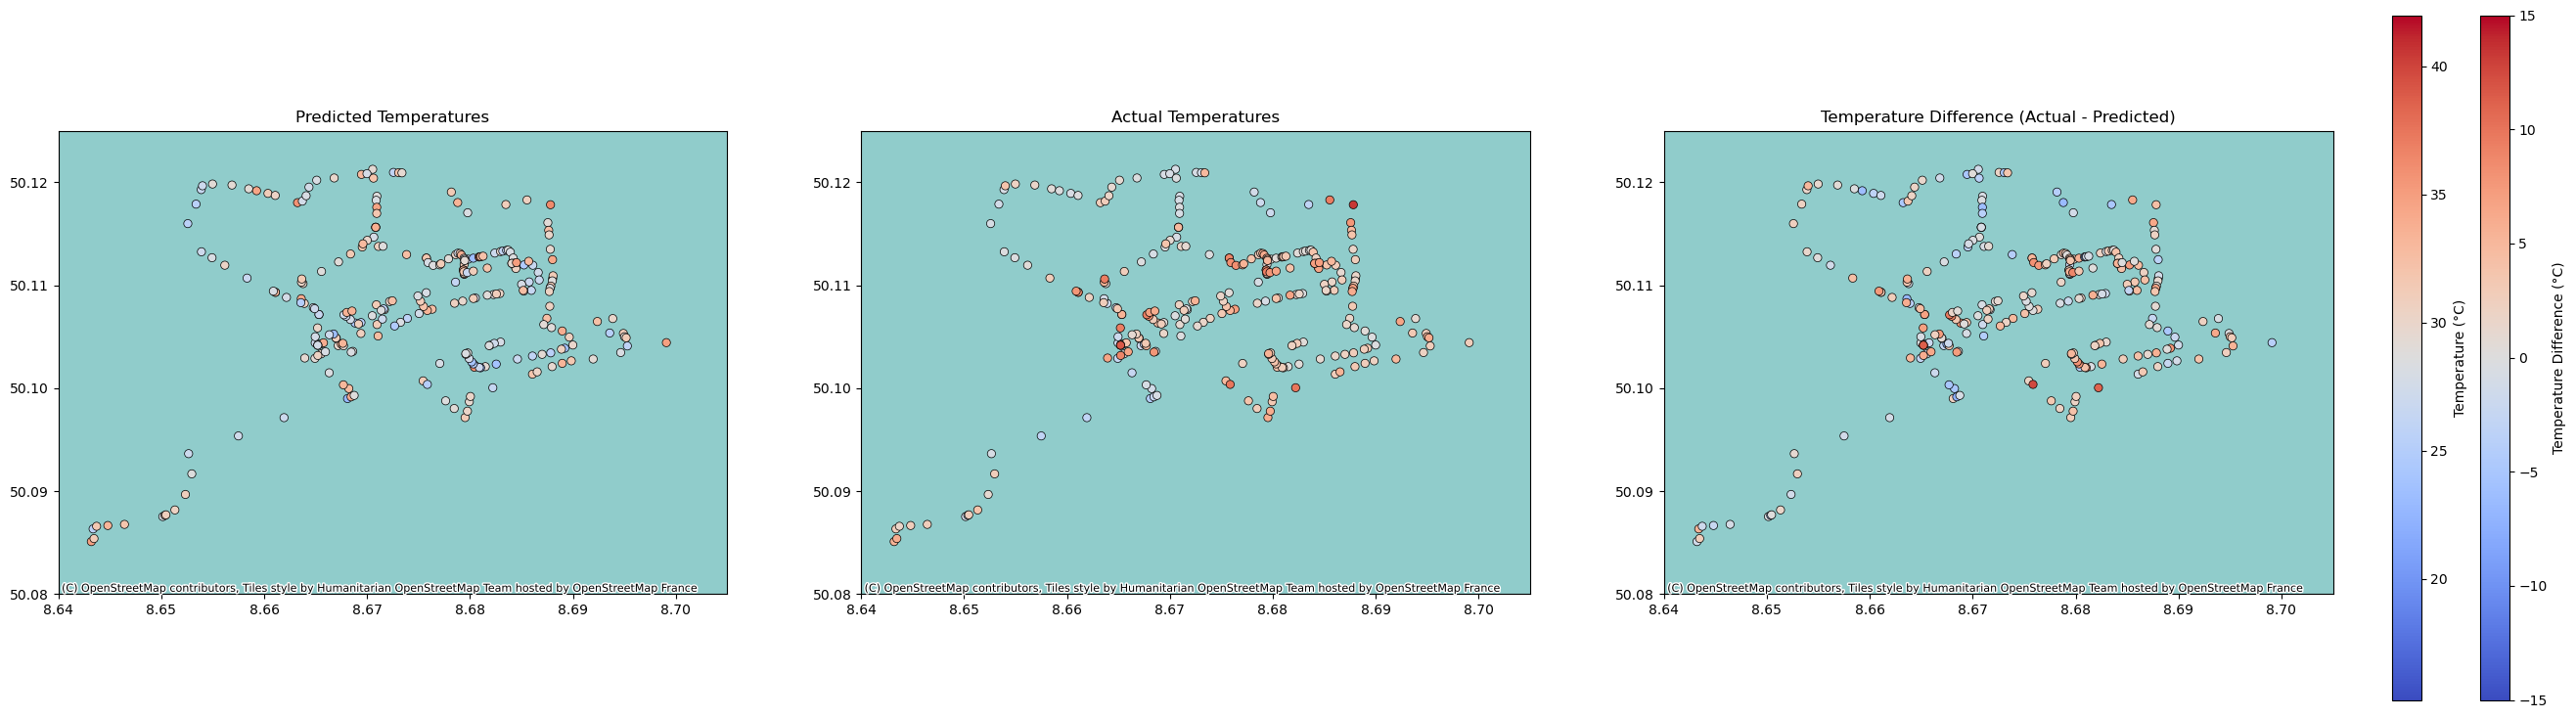

In [52]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np

def visualize_predictions_on_map(predictions, actuals, coords):
    # Reverse the order of coordinates (assuming coords are given as (longitude, latitude))
    geometry = [Point(xy[::-1]) for xy in coords]
    gdf = gpd.GeoDataFrame(
        {
            'Predicted Temperature': predictions, 
            'Actual Temperature': actuals,
            'Temperature Difference': np.array(actuals) - np.array(predictions)  # Compute the difference
        },
        geometry=geometry,
        crs='EPSG:4326'  # Explicitly set the CRS to EPSG:4326
    )
    # gdf = gdf.to_crs(epsg=3857)

    print(gdf.head())
    print(coords[:5])

    # Set up the plot with subplots
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))  # 1 row, 3 columns

    vmin, vmax = np.min([predictions, actuals]), np.max([predictions, actuals])  # Min and max values for color scaling

    # Plot predicted temperatures
    im = gdf.plot(
        ax=axs[0],
        column='Predicted Temperature',
        cmap='coolwarm',
        edgecolor='black',  # Specify edgecolor
        linewidth=0.5,  # Specify linewidth
        vmin=vmin, vmax=vmax  # Set min and max values for color scaling
    )
    axs[0].set_title('Predicted Temperatures')
    axs[0].set_xlim([8.64, 8.705])  # Adjust these values to zoom in on Frankfurt
    axs[0].set_ylim([50.08, 50.125])  # Adjust these values to zoom in on Frankfurt
    cx.add_basemap(axs[0])

    # Plot actual temperatures
    gdf.plot(
        ax=axs[1],
        column='Actual Temperature',
        cmap='coolwarm',
        edgecolor='black',  # Specify edgecolor
        linewidth=0.5,  # Specify linewidth
        vmin=vmin, vmax=vmax  # Set min and max values for color scaling
    )

    axs[1].set_title('Actual Temperatures')
    axs[1].set_xlim([8.64, 8.705])  # Adjust these values to zoom in on Frankfurt     #Frankfurt: 8.64, 8.705  #lindau 9.684, 9.7 
    axs[1].set_ylim([50.08, 50.125])  # Adjust these values to zoom in on Frankfurt   #Franlfirt : 50.08, 50.125   #lindau , 47.54, 47.55
    cx.add_basemap(axs[1])

    # Plot temperature differences
    diff_vmin, diff_vmax = np.min(gdf['Temperature Difference']), np.max(gdf['Temperature Difference'])  # Min and max values for color scaling of differences
    im_diff = gdf.plot(
        ax=axs[2],
        column='Temperature Difference',
        cmap='coolwarm',
        edgecolor='black',
        linewidth=0.5,
        vmin=-15, vmax=15
    )
    axs[2].set_title('Temperature Difference (Actual - Predicted)')
    axs[2].set_xlim([8.64, 8.705])  # Adjust these values to zoom in on Frankfurt     #Frankfurt: 8.64, 8.705  #lindau 9.684, 9.7 
    axs[2].set_ylim([50.08, 50.125])  # Adjust these values to zoom in on Frankfurt   #Franlfirt : 50.08, 50.125   #lindau , 47.54, 47.55
    cx.add_basemap(axs[2])


   # Create colorbar for predicted and actual temperatures
    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    cbar = plt.colorbar(im.collections[0], cax=cbar_ax, orientation='vertical')
    cbar.set_label('Temperature (°C)')

    # Create colorbar for temperature differences
    cbar_diff_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
    cbar_diff = plt.colorbar(im_diff.collections[0], cax=cbar_diff_ax, orientation='vertical')
    cbar_diff.set_label('Temperature Difference (°C)')

    plt.show()

# Usage:
visualize_predictions_on_map(predictions, actuals, coords)